Imports, loading data and creating the graph

In [3]:
from collections import defaultdict
from itertools import combinations
from pathlib import Path
from gensim.models import Word2Vec
import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import pyplot


In [4]:
# Reads csv file into a pandas dataframe
articles = pd.read_csv(Path("data") / "articles.csv")

# Adds a new columns called node_id which corresponds to the index
articles["node_id"] = articles.index

# Make List into an array
articles["lists"] = articles["lists"].str.split("; ")
test_data = pd.read_csv(Path("data") / "test_data.csv")
train_data = pd.read_csv(Path("data") / "train_data.csv")

In [5]:
medium_graph = nx.Graph()
medium_graph.add_nodes_from(articles["node_id"].to_list())

list_to_nodes = defaultdict(set)
for _, row in articles[["node_id", "lists"]].iterrows():
    for l in row["lists"]:
        list_to_nodes[l].add(row["node_id"])

for node_ids in list_to_nodes.values():
    medium_graph.add_edges_from(combinations(node_ids, 2))

## 1. Familiarization

### Analysis of the Graph Statistics
1. The number of nodes : There are 27718 nodes which is a lot of node
2. The number of edges : The number of edges are 2014162 which is relatively low considering 27718 nodes
3. Number of edges for each node, thee number of neigbours are shown in th plot below.
4. Isolated Nodes : There are 347 nodes that are isolated
5. Since there was a very unusal difference in the number of nodes and edges we thought it would be a good idea to compute the density. The density is around 0.00524 which is very low. Hense the **graph is sparse**. 
6. While trying to calculate the radius and the diameter we were unable to do so, hence we conclusded that the graph was not fully connected. COnsidering the number of isolated nodes we can subtract from it aswell
## TODO: Talk about Sparse, non/Semantic and type of extraction.

1. Number of Nodes: 27718

2. Number of Edges: 2014162

3. Number of Neighbours of Each Node:
[[0, 144], [1, 102], [2, 18], [3, 34], [4, 15], [5, 8], [6, 317], [7, 154], [8, 198], [9, 37], [10, 129], [11, 1], [12, 34], [13, 14], [14, 1], [15, 7], [16, 56], [17, 56], [18, 145], [19, 55], [20, 50], [21, 19], [22, 33], [23, 21], [24, 228], [25, 8], [26, 858], [27, 827], [28, 320], [29, 2], [30, 30], [31, 13], [32, 92], [33, 271], [34, 1], [35, 66], [36, 865], [37, 602], [38, 1152], [39, 23], [40, 60], [41, 310], [42, 6], [43, 310], [44, 4], [45, 47], [46, 324], [47, 69], [48, 320], [49, 77], [50, 57], [51, 100], [52, 103], [53, 353], [54, 827], [55, 3], [56, 93], [57, 291], [58, 10], [59, 747], [60, 7], [61, 165], [62, 6], [63, 215], [64, 57], [65, 149], [66, 115], [67, 18], [68, 33], [69, 24], [70, 5], [71, 16], [72, 44], [73, 80], [74, 52], [75, 67], [76, 19], [77, 3], [78, 1], [79, 21], [80, 8], [81, 28], [82, 455], [83, 435], [84, 24], [85, 32], [86, 187], [87, 5], [88, 108], [89, 157

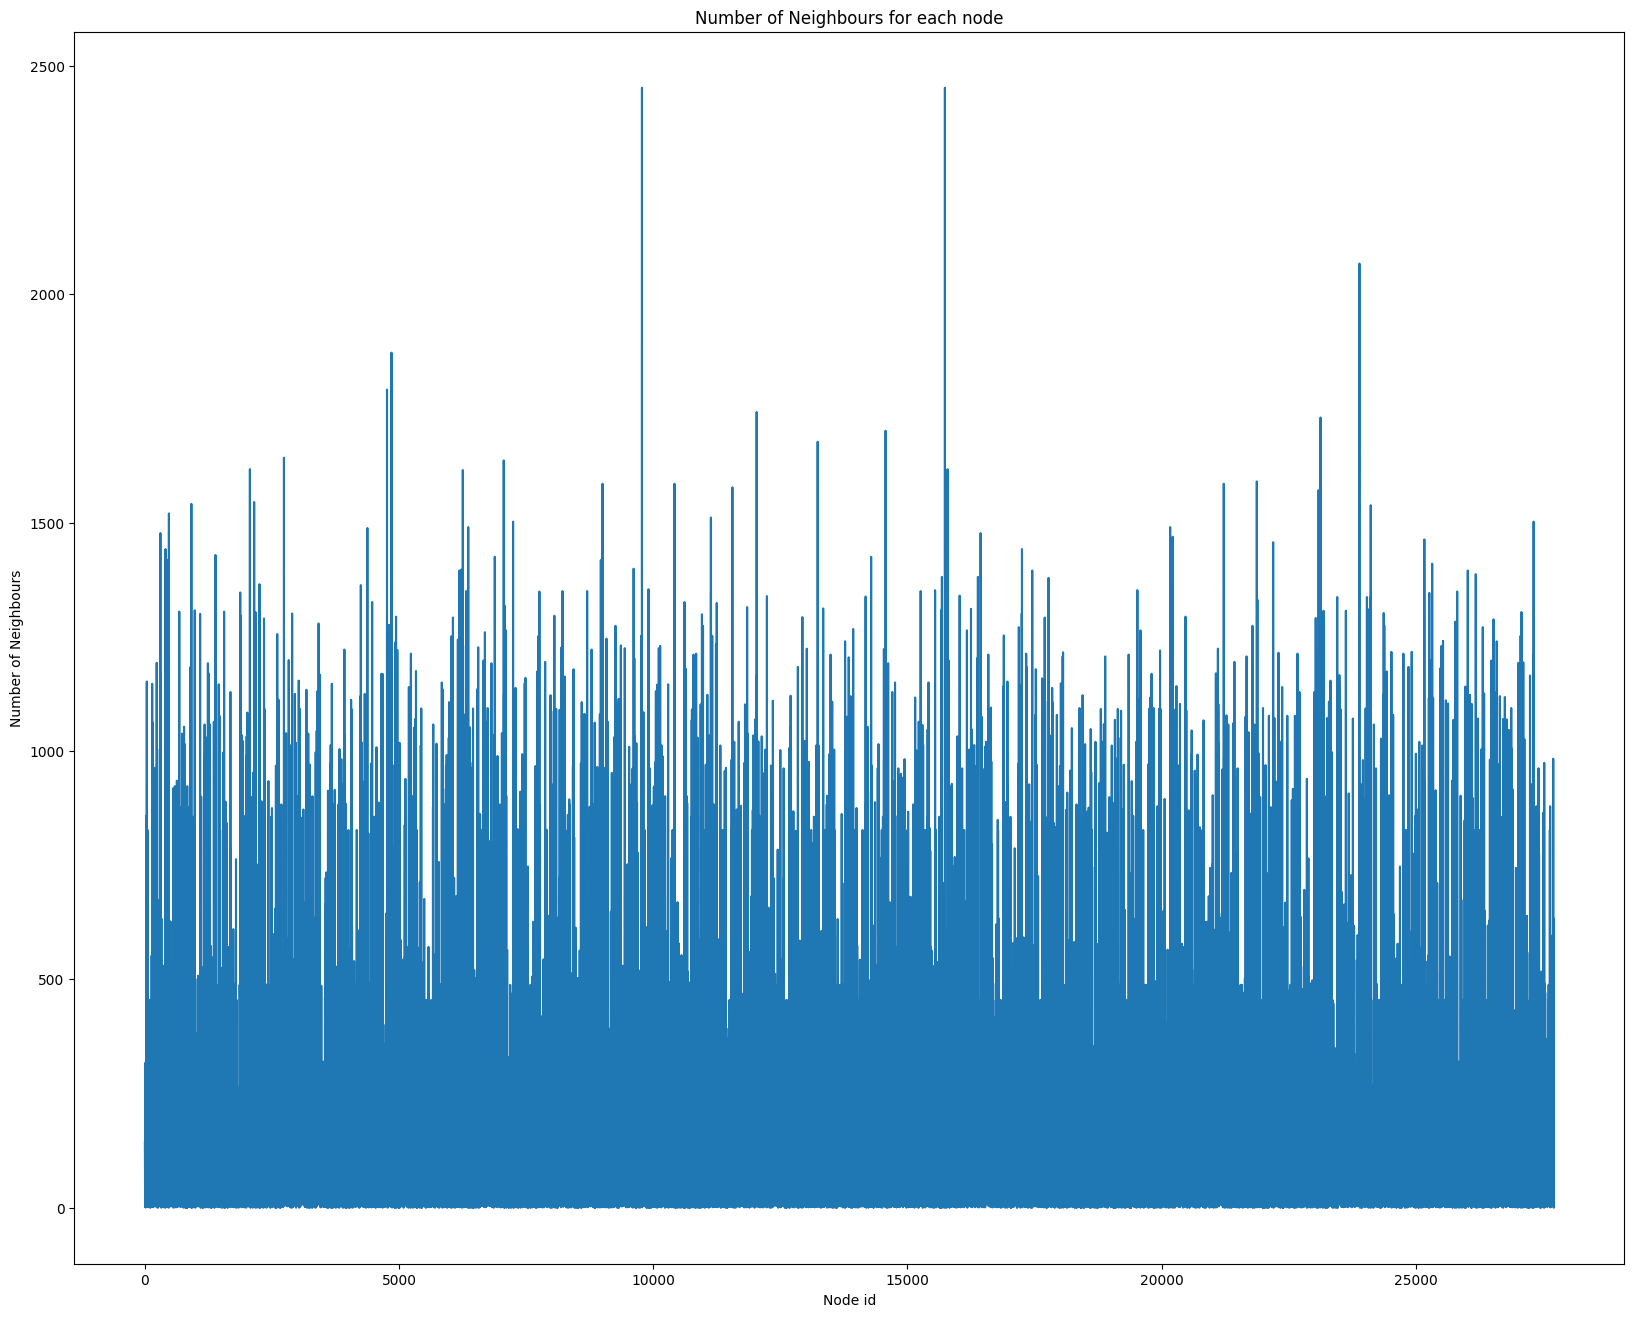

In [11]:
number_nodes = medium_graph.number_of_nodes()
number_edges = medium_graph.number_of_edges()
list_of_node = medium_graph.nodes

nodes_neigbours = []
neighbours = []
nodes_without_neighbours = []
for n in list_of_node:
    neigh = []
    for i in medium_graph.neighbors(n):
        neigh.append(i)
    if(len(neigh) == 0):
        nodes_without_neighbours.append(n)
    neighbours.append(len(neigh))    
    nodes_neigbours.append([n, len(neigh)])
    
density = nx.density(medium_graph)

connected_components = nx.number_connected_components(medium_graph)
connected_components_wo_isolation = connected_components - len(nodes_without_neighbours)


print(f"1. Number of Nodes: {number_nodes}\n")
print(f"2. Number of Edges: {number_edges}\n")
print("3. Number of Neighbours of Each Node:")
print(nodes_neigbours)
print("")
print(f"4. Nodes without Neighbours: {len(nodes_without_neighbours)}")
print(nodes_without_neighbours)
print("")
print(f"5. Density of the graph is : {density}\n")
print(f"6. Number of connected components is : {connected_components}\n")
print(f"   Removing Isolated nodes the number of original graph clusters are: {connected_components_wo_isolation}\n")

pyplot.figure(figsize=(20,16))
pyplot.xlabel("Node id")
pyplot.ylabel("Number of Neighbours")
pyplot.title("Number of Neighbours for each node")
pyplot.plot([i for i in range(len(neighbours))],neighbours)
pyplot.show()

## Analysis From Familiarization:

### For Spectral Embedding:
- There are a 760 connected componenets out of which there are 347 isolated nodes (nodes without neigbours). 
- Extensions and consideratoin we should make whil approaching spectral Embedding:
    1. Isolated nodes will have an adverse impact on the clusterings as in the adjacency matrix they provide no semantic (logical) meaning. Hence ideally we should remove isolated nodes. However this will cause too much overhead and since there are only 347 isolated nodes out of 27718 we need not consider it.
    2. Having a not fully connected graph signifies a collection of orignal clusters. As our graph is mostly sparse spectral embedding will turnout to be less effective, as the spectral information is more spread out across the spectrum in sparse graphs. This characteristc makes it more difficult to capture meaningful structural patterns using only a few eigenvectors. Hence we should use a large number of eigenvectors to understand the data better.
- When approaching our specatral embedding we do not need to remove isolated nodes, as there are very few, and we should take a large eigenvector componenets when training our model. 

### For Random Walks:

## 2. Spectral Node Embedding Computation
1. Calculate the Laplician Matrix
2. Eigenvectors of the Laplacian Matrix are created to generate the embeddings
3. Each row of the eigen-matrix is an embedding of its corresponsind node, since it is best not to take all the eigen componenets we create an elbow curve
4. The elbow curve show the explained variance, since the eigenvalues are ascending we get a elbow curve that is flipped
5. Upon analysis of the elbow curve the ideal number of componenets is around 10000
6. Computing a distance matrix to do the KNN (k nearest neighbour calculations)

## Optimizations

1. The eigenmatrix and distance matrix calculation is the most computationally expensive operation, so we decided to create a distance matrix and save it as a CSV file using 32-bit float precision to reduce memory requirements
## Extensions:
- Normalise the Laplacian by first removing isolated nodes_

In [12]:
def embeddings(graph: nx.Graph):
    # Create adjacency matrix with 32-bit float precision
    adjacency_matrix = nx.to_numpy_array(graph, nodelist=sorted(graph.nodes), dtype=np.float32)
    
    # Degree matrix (diagonal matrix with node degrees)
    degree_matrix = np.diag(adjacency_matrix.sum(axis=1)) 
    
    # Laplacian matrix: Degree matrix - Adjacency matrix
    laplacian_matrix = degree_matrix - adjacency_matrix
    
    # Eigen decomposition: Using eigh for symmetric matrices
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    return eigenvalues, eigenvectors

Calculating Embeddings

In [13]:
eigenvalues, eigenvectors = embeddings(medium_graph) 
print(eigenvalues)

[-9.9049013e-13 -9.5724589e-13 -3.1716646e-13 ...  2.0680583e+03
  2.4530000e+03  2.4531216e+03]


### Preprocessing Step
- Trying to find how many eigenvalues are negative or zero to disclude them from the embedding.
- The result is to remove the first 760

In [36]:
def count_negative_eigenvalues(eigenvalues):
    count = 0
    for value in eigenvalues:
        if value < 1e-7:
            count += 1
        else:
            break
    return count

print(f"Number of Negative Eigenvalues Or Zero eigenvalues: {count_negative_eigenvalues(eigenvalues)}")

Number of Negative Eigenvalues and zero eigen values: 760


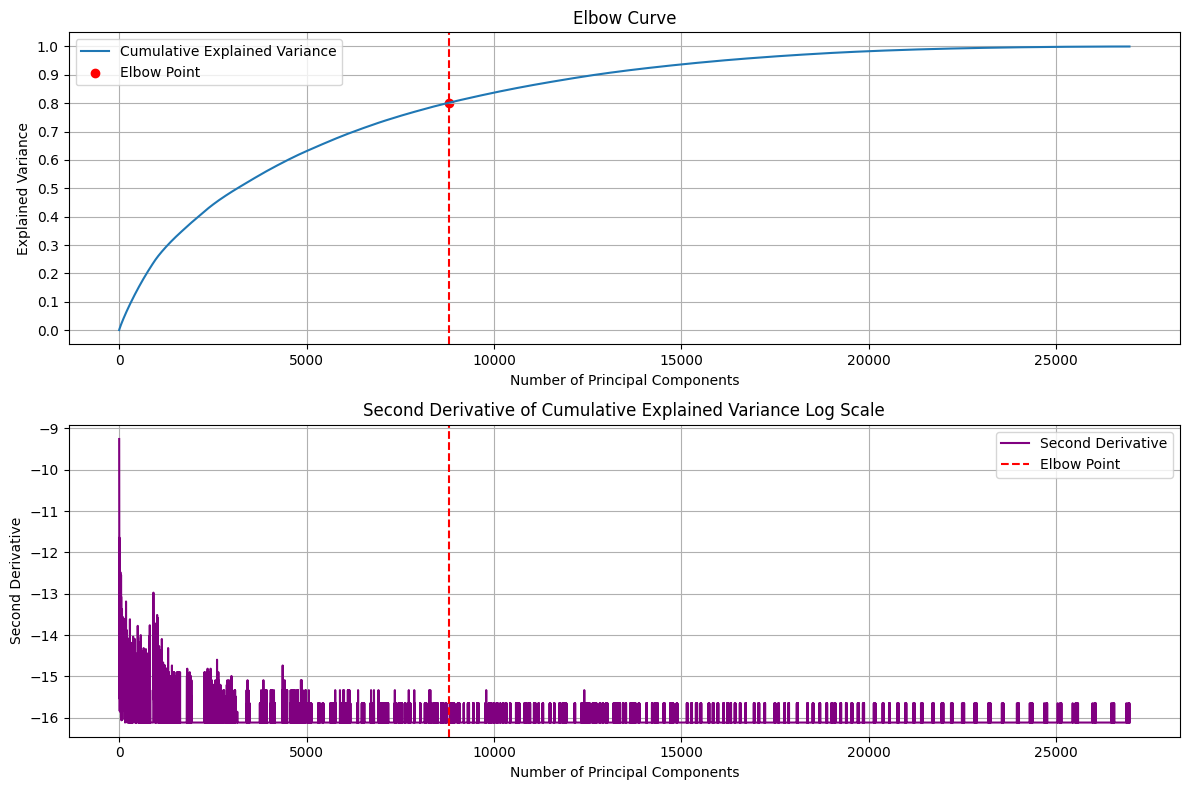

Elbow Point detected at index: 8800


In [42]:
eig_sorted = np.sort(eigenvalues[760:])[::-1]
explained_variance_ratio = eig_sorted / np.sum(eig_sorted)
cumulative_variance = np.cumsum(explained_variance_ratio)

second_derivative = np.diff(np.diff(cumulative_variance))
log_second_derivative = np.log(np.abs(second_derivative)+ 0.0000001)

elbow_index = 8800
pyplot.figure(figsize=(12, 8))

pyplot.subplot(2, 1, 1)
pyplot.plot(cumulative_variance, label='Cumulative Explained Variance')
pyplot.scatter(elbow_index, cumulative_variance[elbow_index], color='red', label='Elbow Point')
pyplot.axvline(x=elbow_index, color='red', linestyle='--')
pyplot.title("Elbow Curve")
pyplot.xlabel("Number of Principal Components")
pyplot.ylabel("Explained Variance")
pyplot.yticks(np.arange(0, 1.1, 0.1)) 
pyplot.legend()
pyplot.grid(True)


pyplot.subplot(2, 1, 2)
pyplot.plot(log_second_derivative, label='Second Derivative', color='purple')
pyplot.axvline(x=elbow_index - 1, color='red', linestyle='--', label='Elbow Point')
pyplot.title("Second Derivative of Cumulative Explained Variance Log Scale")
pyplot.xlabel("Number of Principal Components")
pyplot.ylabel("Second Derivative")
pyplot.legend()
pyplot.grid(True)

pyplot.tight_layout()
pyplot.show()

print(f"Elbow Point detected at index: {elbow_index}")

Computing Distance Matrix: We only ran this once, as we decided to save it in a CSV file to reduce eigenvector computation

In [43]:
def compute_distances(matrix, location):
    squared_matrix = np.sum(matrix**2, axis=1).reshape(-1, 1)
    squared_distances = squared_matrix + squared_matrix.T - 2 * np.dot(matrix, matrix.T)
    np.fill_diagonal(squared_distances, np.inf)
    distances = np.sqrt(squared_distances)
    
    print("Saving eigenvectors to CSV...")
    pd.DataFrame(distances).to_csv(location, index=False, header=False)
    return distances

In [44]:
output_csv_path = "distance_matrix_2.csv"
distance = compute_distances(eigenvectors[:,760:8800], output_csv_path)
# distance = pd.read_csv("distance_matrix_2.csv")

C:\Users\satya\AppData\Local\Temp\ipykernel_11852\3597236417.py:5: RuntimeWarning: invalid value encountered in sqrt
  distances = np.sqrt(squared_distances)


Saving eigenvectors to CSV...


In [45]:
distance = np.array(distance)

Creating a big dictionary to find the labels for the KNN classifier

In [46]:
def create_node_label_dict(csv_file_path):
    df = pd.read_csv(csv_file_path)
    node_label_dict = pd.Series(df['label'].values, index=df['node_id']).to_dict()
    
    return node_label_dict
csv_file_path = Path("data") / "train_data.csv" 
dict_labels = create_node_label_dict(csv_file_path)

In [47]:
def knn_calc(matrix, k, dict_labels):
    classification = []
    
    for i in range(len(matrix)):
        nearest_neighbors = np.argsort(matrix[i])[:k]
        label_counts = [0, 0, 0, 0]  # Software Development, AI, UX, Other
        
        for neighbor_index in nearest_neighbors:
            label = dict_labels.get(neighbor_index, 'unknown')
            
            if label == "artificial-intelligence":
                label_counts[1] += 1
            elif label == "software-development":
                label_counts[0] += 1
            elif label == "ux":
                label_counts[2] += 1
            else:
                label_counts[3] += 1
        
        npLabels = np.array(label_counts)
        
        max_index = npLabels.argmax()
        
        if max_index == 0:
            ofClass = "software-development"
        elif max_index == 1:
            ofClass = "artificial-intelligence"
        elif max_index == 2:
            ofClass = "ux"
        else:
            ofClass = "other"
        classification.append(ofClass)

    return classification


In [68]:
result = knn_calc(distance, 30, dict_labels)

Making a graph would take too much time, hence here are some accuracy values we got:
k = 10, Accuracy =  72.4%
k = 100, Accuracy =  73.5%
k = 50, Accuracy = 75.2%
k = 30, Accuracy =  75.5%
k = 25, Accuracy =  75.3%

Therefore 30 is a good option. 

In [69]:
csv_file_path_test = Path("data") / "test_data.csv" 
dict_labels_test = create_node_label_dict(csv_file_path_test)
c = 0
t = 0
for i in range(len(result)):
    prediction = result[i]
    test = dict_labels_test.get(i)
    tOf = test == prediction
    if(test == None):
        continue
    if(test == prediction):
        c = c+1
    t = t+1
accuracy = c / t

print(accuracy)

0.7549367088607595


## Analysis and Evaluation of Spectral Embedding:

## 3. Word2Vec Computing Embeddings


Steps:
1. Define an econder here we will use Node2Vec
    Here we can use : DeepWalk, node2vec, TransE
2. Define a node similarity function
    Random Walk : similarity between node u and v is defined as the probability that u and v co-occur on a random walk over a network
3. Optimize the parameters of the encoder so that similarity of u anv v in the network approximate the do product between node embedding: simularity(u,v) ~ ZuT*Zv

In [9]:
# Performing Random Walk
def random_walks(graph: nx.Graph, num_walks: int, walk_length: int) -> np.ndarray:
    result = []

    for node in graph.nodes():
        for i in range(num_walks):
            walk = [node]
            for j in range(walk_length - 1):
                current_node = walk[-1]
                neighbors_list = list(graph.neighbors(current_node))
                
                if len(neighbors_list) == 0:
                    break  # Stop walk if there are no neighbors (isolated node)
                
                # Randomly choose a neighbor
                index = np.random.randint(len(neighbors_list))
                next_node = neighbors_list[index]
                walk.append(next_node)
                
             # Pad shorter walks with None as we want to create equal length np arrays   
            if len(walk) < walk_length:
                walk.extend([None] * (walk_length - len(walk)))
            result.append(walk)

    return result


In [10]:
walks = random_walks(graph = medium_graph, num_walks= 5, walk_length = 50)

- In the Word2Vec each walk is treated like a sentence
- 

In [11]:
# walks = [list(filter(lambda x: x is not None, walk)) for walk in randomWalks] ## Removing the None values

## Each Walk is treated like a sentence
model = Word2Vec(sentences=[list(map(str, walk)) for walk in walks], vector_size=128, window=5, min_count=1, sg=0)

node_id = 0
vector = model.wv[node_id]
print(f"Vector for node {node_id}: {vector}")


Vector for node 0: [ 0.04464827  0.48899785  1.8551004   2.574473   -1.5879902  -2.1247396
 -0.33649838  2.0064492  -2.2776473  -2.5447006   1.1965591   0.38653123
  0.49140963 -0.40435892 -2.1597328   0.21571739  1.1756296  -0.07675742
 -1.9090948  -3.5822103   1.1842453   1.3795671   2.4832315   1.2993138
  1.2897567  -0.5405788   0.80309397  0.4414345  -0.5793171  -0.09252043
 -0.59640324 -1.3474857   0.84234434 -1.7660366  -0.79432887  1.4297647
  0.91126484 -1.9132389  -0.09321629 -1.2340575  -4.0022054   1.6849432
 -2.4968297  -1.3324717   1.3312261  -0.49138248 -0.82245386  3.9593341
  0.62198585  2.6255786  -3.0406625   0.17120641 -0.7756366   0.01581608
  0.8457923   0.58580405 -0.2293783  -1.5431583  -0.24572758  1.957846
 -1.5589237   1.1012049  -1.2544649  -2.2272804   1.161174   -0.40663517
  0.2607551  -1.6499565  -0.08034634 -1.5659165   0.5385303   0.7855318
 -1.3461723  -3.0407934   0.37013787 -1.618596    2.3212469   1.5086035
 -1.0348325  -1.5988256   0.25744557 -0.1